In this example, we will train a linear Koopman model using EDMD (see Williams, Kevrekidis & Rowley, “A Data–Driven Approximation of the Koopman Operator: Extending Dynamic Mode Decomposition”, Journal of Nonlinear Science 25, pp. 1307-1346, 2015) for a nonlinear, dynamical system. 

Load Data

In [6]:
from robot_tools import recorder
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data = recorder.json_process("data_sim_1.json")["0"]
observation = np.array(data["observation"])
action = np.array(data["action"]).T
num = data["num"]
states = observation.T

n_states = 6  # Number of states, x y yaw ax ay ayaw
n_traj = 1  # Number of trajectories
n_int = num -1  # Integration length


In [8]:
X = np.delete(states,-1,axis=1)
Y = np.delete(states,0,axis=1)
U = np.delete(action,-1,axis=1)

print(X[:,0:3])
print(Y[:,0:3])
print(U[:,0:3])

[[207.04348755 117.58218384  99.50003052]
 [127.30657959 119.78076172  73.5       ]
 [  0.36314698   0.35877071   0.        ]]
[[117.58218384  99.50003052  99.5       ]
 [119.78076172  73.5         73.5       ]
 [  0.35877071   0.           0.        ]]
[[0.         0.02070435 0.01175822]
 [0.02043355 0.         0.        ]
 [0.         0.         0.35877071]]


Text(0.5, 1.0, 'training data. num traj = 1, each traj time step = 31')

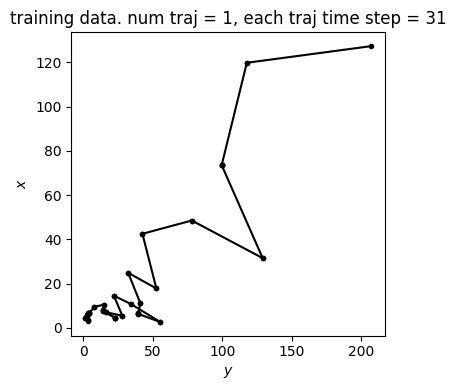

In [18]:
# Visualize some steps of the training data
num = 30
X_P = X[:2,:num]
Y_P = Y[:2,:num]

fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 4))
for traj_idx in range(n_traj):
    axs.plot(
        [X_P[0, traj_idx::n_traj], Y_P[0, traj_idx::n_traj]],
        [X_P[1, traj_idx::n_traj], Y_P[1, traj_idx::n_traj]],
        "-ok",
        markersize=3,
    )
axs.set(ylabel=r"$x$", xlabel=r"$y$")
axs.set_title(
    "training data. num traj = {}, each traj time step = {}".format(n_traj, n_int)
)

In [19]:
import pykoopman as pk
import warnings
np.random.seed(42)  # for reproducibility
warnings.filterwarnings("ignore")
from pykoopman.regression import EDMD, EDMDc
from pykoopman.observables import RadialBasisFunction, Polynomial

Koopman regression using EDMD

In [20]:
EDMDc_ = EDMDc()
RBF = RadialBasisFunction(rbf_type='thinplate', n_centers=20,
                                         centers=None, kernel_width=1.0,
                                         polyharmonic_coeff=1.0, include_state=True)
model = pk.Koopman(observables=RBF, regressor=EDMDc_)
# 拟合
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[7.81368168e+01, 2.02887358e+02, 1.55531047e+02, 1.26661877e+02,
        3.08235680e+01, 3.08183457e+01, 9.61913366e+00, 1.84583550e+02,
        1.27193753e+02, 1.50351705e+02, 1.50000000e+00, 2.07043488e+02,
        1.77279730e+02, 4.30178129e+01, 3.64110333e+01, 3.67530284e+01,
        6.29162494e+01, 1.10660950e+02, 9.05658573e+01, 6.0098713...
       [3.40353523e-02, 1.78929223e-01, 0.00000000e+00, 3.39745717e-01,
        8.71336835e-02, 2.43911281e-01, 1.07687412e-01, 1.88594716e-01,
        1.98940200e-01, 5.84275849e-02, 3.63146982e-01, 2.87639198e-01,
        3.51464377e-01, 3.34117905e-01, 2.18817726e-01, 3.44620509e-01,
        2.10091736e-02, 6.27488683e-02, 4.20881330e-03, 1.12975919e-01]]),
                                        n_centers=20, rbf_type='thinplate'),
        regressor=EDMDc())

In [ ]:
# # Polynomial basis functions
# EDMD_ = EDMD()
# POLY = Polynomial(degree=2, include_bias=True)
# model = pk.Koopman(observables=RBF, regressor=EDMD_)
# model.fit(X.T, y=Y.T)

Prediction

In [21]:
# prepare starting point and true trajectory
start = 0
x0 = X[:, start]
lenth = 5
t = np.arange(0, lenth, 1)
end = start + lenth
Xtrue = X[:, start : start + end].T
print(x0)
print(Xtrue)

[207.04348755 127.30657959   0.36314698]
[[207.04348755 127.30657959   0.36314698]
 [117.58218384 119.78076172   0.35877071]
 [ 99.50003052  73.5          0.        ]
 [ 99.5         73.5          0.        ]
 [129.00003052  31.50006104   0.        ]]


In [22]:
# Simulate (multi-step prediction) Koopman model
Xkoop = model.simulate(x0[np.newaxis, :], U.T , n_steps=len(t)-1)
Xkoop = np.vstack([x0[np.newaxis,:], Xkoop])  # add initial point
print(x0[np.newaxis, :])
print(Xkoop)

[[207.04348755 127.30657959   0.36314698]]
[[ 2.07043488e+02  1.27306580e+02  3.63146982e-01]
 [ 1.17599569e+02  1.19773505e+02  3.58769913e-01]
 [ 8.47391380e+01  7.92806483e+01 -1.33344303e-02]
 [ 2.05016352e+04 -7.91910575e+03  1.89282456e+01]
 [ 5.36129178e+08 -2.10847414e+08  4.55119924e+05]]


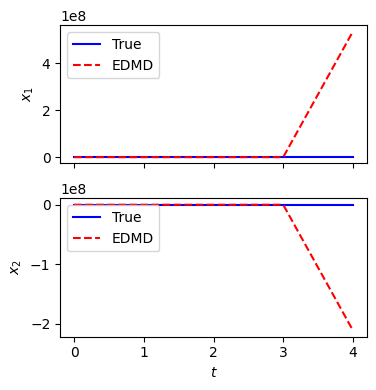

In [24]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(4, 4))
axs[0].plot(t, Xtrue[:, 0], '-', color='b', label='True')
axs[0].plot(t, Xkoop[:, 0], '--r', label='EDMD')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtrue[:, 1], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 1], '--r', label='EDMD')
axs[1].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')
for i in range(2):
    axs[i].legend(loc='best')

In [75]:
# Init
Xk = np.zeros((n_states, n_int*n_traj))
Yk = np.zeros((n_states, n_int*n_traj))
# 1-step prediction using Koopman model
x = x0[np.newaxis, :]
print(x)

[[-6.25e+01  5.00e-01  0.00e+00  0.00e+00  0.00e+00  1.50e-03]]


In [76]:
for k in range(n_int):
    yT = model.predict(x)
    y = yT.T
    Xk[:, k*n_traj:(k+1)*n_traj] = x.T
    Yk[:, k*n_traj:(k+1)*n_traj] = y
    x = y.T

In [80]:
print(X[:,0:3])
print(Xk[:,0:3])

[[-6.2500000e+01 -6.2999939e+01 -6.2500000e+01]
 [ 5.0000000e-01  2.3500061e+01  2.3500000e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.0000000e-03  0.0000000e+00]
 [ 1.5000000e-03  0.0000000e+00  5.0000000e-03]]
[[-6.25000000e+01 -6.15803903e+01 -6.07654374e+01]
 [ 5.00000000e-01 -1.43882875e-01  1.67276711e-01]
 [ 0.00000000e+00  8.87453216e-06 -2.73902482e-05]
 [ 0.00000000e+00 -1.14734487e-04 -3.47130864e-06]
 [ 0.00000000e+00  3.00235207e-04  1.67095234e-04]
 [ 1.50000000e-03 -2.95223800e-04 -7.71247334e-05]]


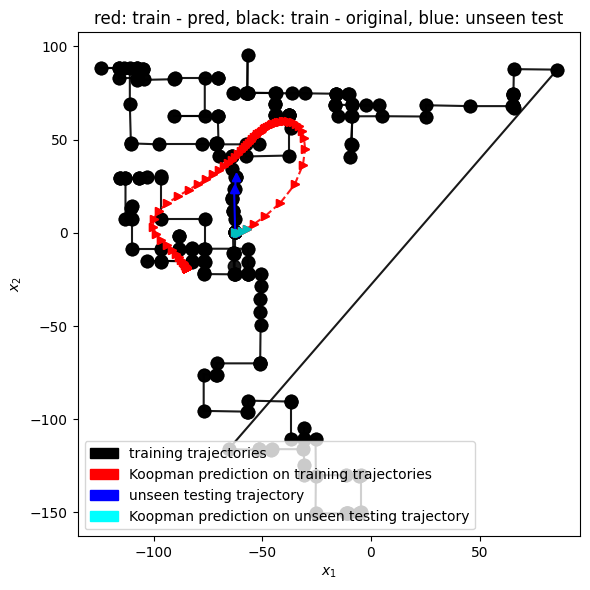

In [78]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
legend_list = ['training - true', 'training - pred']
for traj_idx in range(n_traj):
    # label = legend_list[0] if traj_idx == 0 else None
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]],'-ok',alpha=0.9,markersize=9)
    # label = legend_list[1] if traj_idx == 0 else None
    axs.plot([Xk[0, traj_idx::n_traj], Yk[0, traj_idx::n_traj]],
             [Xk[1, traj_idx::n_traj], Yk[1, traj_idx::n_traj]], '-->r',alpha=0.9)
axs.set(ylabel=r'$x_2$',
        xlabel=r'$x_1$')

axs.plot(Xtrue[:,0], Xtrue[:,1],'-^b')
axs.plot(Xkoop[:,0], Xkoop[:,1],'->c')

axs.scatter(x0[0],x0[1],s=50,c='b',label='unseen test')
axs.set_title('red: train - pred, black: train - original, blue: unseen test')

red_patch = mpatches.Patch(color='black', label='training trajectories')
black_patch = mpatches.Patch(color='red', label='Koopman prediction on training trajectories')
blue_patch = mpatches.Patch(color='blue', label='unseen testing trajectory')
cyan_patch = mpatches.Patch(color='cyan', label='Koopman prediction on unseen testing trajectory')

axs.legend(handles=[red_patch, black_patch, blue_patch, cyan_patch],loc='best', )

Test

In [51]:
# x0 = [0.6, -0.6]
from pykoopman.common import rev_dvdp  # discrete-time, reverse-time van der Pol

dT = 0.1
x0 = np.array([0.5, -0.75])
T = 10
t = np.arange(0, T, dT)

# Integrate
Xtrue = np.zeros((len(t), n_states))
Xtrue[0, :] = x0
for step in range(len(t) - 1):
    y = rev_dvdp(0, Xtrue[step, :][:, np.newaxis], 0, dT)
    Xtrue[step + 1, :] = y.ravel()

print(x0)
print(x0[np.newaxis, :])

[ 0.5  -0.75]
[[ 0.5  -0.75]]
